# Inspect the single-lineage model run on the liver data (007)

 Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.
- varying effect for cell line and varying copy number effect for cell line

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager, broad_only
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-liver-007_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-liver-007'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-liver-007",
    "description": " Single lineage hierarchical negative binomial model for liver data from the Broad. Varying effect for cell line and varying effect for copy number per cell line. This model also uses a different transformation for the copy number data. The `max_tree_depth` is also increased with the intention to give the tuning process a little more room to experiment with, but it should not be used as the tree depth for the final draws. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_liver.csv",
    "model_kwargs": {
        "lineage": "liver",
        "min_frac_cancer_genes": 0.2
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro":

### Load posterior summary

In [7]:
liver_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
liver_post_summary.head()

parameter    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a   0.075  0.008     0.062      0.088      0.000    0.000     414.0   
1      mu_b   0.001  0.000     0.001      0.002      0.000    0.000    3573.0   
2      mu_m  -0.115  0.027    -0.158     -0.072      0.001    0.001     703.0   
3   sigma_a   0.200  0.001     0.199      0.201      0.000    0.000    1351.0   
4     alpha  10.088  0.013    10.067     10.107      0.000    0.000    3889.0   

   ess_tail  r_hat var_name  
0     730.0    1.0  mu_mu_a  
1    3346.0    1.0     mu_b  
2    1552.0    1.0     mu_m  
3    2085.0    1.0  sigma_a  
4    2661.0    1.0    alpha

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### liver data

In [9]:
liver_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_liver.csv",
    transformations=[broad_only],
)

In [10]:
liver_data = liver_dm.get_data(read_kwargs={"low_memory": False})
liver_data.head()

sgrna                  replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  JHH-6-311Cas9_RepA_p6_batch3  0.561251           3   
1  AAATCAGAGAAACCTGAACG  JHH-6-311Cas9_RepA_p6_batch3 -0.407068           3   
2  AACGTCTTTGAAGAAAGCTG  JHH-6-311Cas9_RepA_p6_batch3  0.074256           3   
3  AACGTCTTTGAAGGAAGCTG  JHH-6-311Cas9_RepA_p6_batch3  0.196487           3   
4  AAGAGGTTCCAGACTACTTA  JHH-6-311Cas9_RepA_p6_batch3 -0.018563           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number lineage  \
0                 NaN       False     0.963953   liver   
1                 NaN       False     1.300097   liver   
2                 NaN       False     0.718530   liver   
3                 NaN       False     0.718530   liver   
4                 NaN       False     0.623693   liver   

            lineage_subtype primary_or_metastasis  is_male   age  
0  hepatocellular_carcinoma               primary    False  57.0  
1  hepatocellular_carcinoma               primary    False  57.0  
2  hepatocellular_carcinoma               primary    False  57.0  
3  hepatocellular_carcinoma               primary    False  57.0  
4  hepatocellular_carcinoma               primary    False  57.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
liver_model = LineageHierNegBinomModel(lineage="liver", min_frac_cancer_genes=0.2)

In [12]:
valid_liver_data = liver_model.data_processing_pipeline(liver_data.copy())
liver_mdl_data = liver_model.make_data_structure(valid_liver_data)

[INFO] 2022-08-05 06:55:29 [(lineage_hierarchical_nb.py:data_processing_pipeline:274] Processing data for modeling.
[INFO] 2022-08-05 06:55:29 [(lineage_hierarchical_nb.py:data_processing_pipeline:275] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-05 06:57:10 [(lineage_hierarchical_nb.py:data_processing_pipeline:326] number of data points dropped: 58
[INFO] 2022-08-05 06:57:11 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:523] number of genes mutated in all cells lines: 0
[DEBUG] 2022-08-05 06:57:11 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:526] Genes always mutated: 
[INFO] 2022-08-05 06:57:12 [(lineage_hierarchical_nb.py:_trim_cancer_genes:579] Dropping 9 cancer genes.
[DEBUG] 2022-08-05 06:57:12 [(lineage_hierarchical_nb.py:_trim_cancer_genes:580] Dropped cancer genes: ['APC', 'ARID1B', 'ARID2', 'AXIN2', 'CASP8', 'FAT4', 'HNF1A', 'IL6ST', 'SMAD2']


In [13]:
liver_mdl_data.coords["cancer_gene"]

['AXIN1']

## Analysis

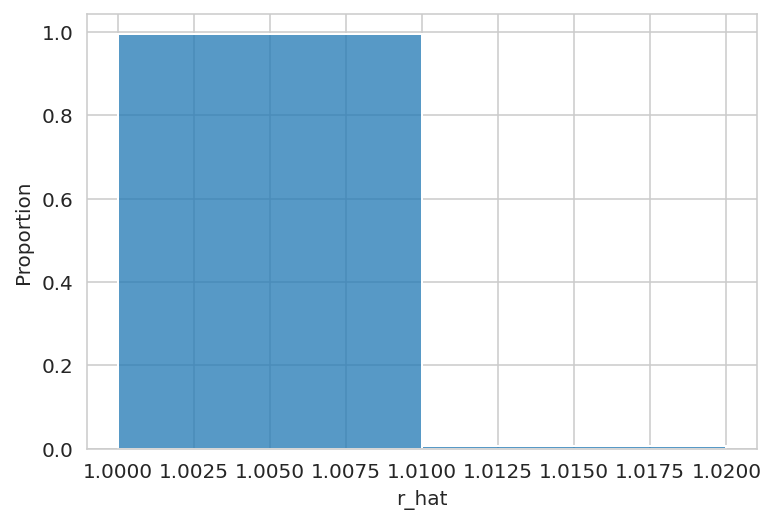

In [14]:
sns.histplot(x=liver_post_summary["r_hat"], binwidth=0.01, stat="proportion");

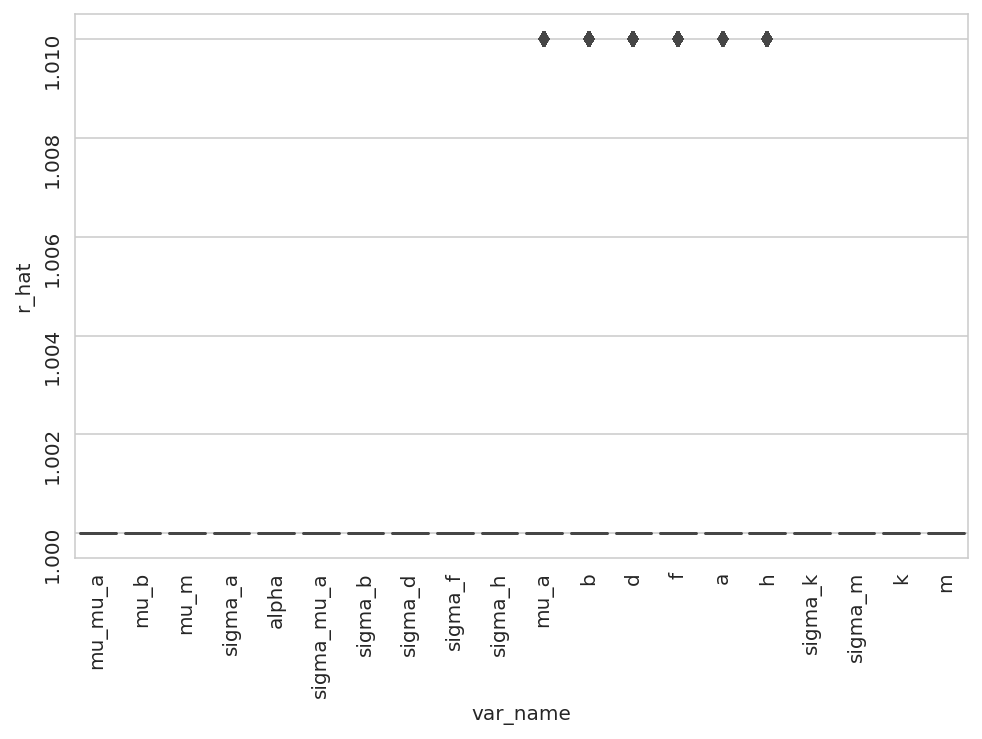

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=liver_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

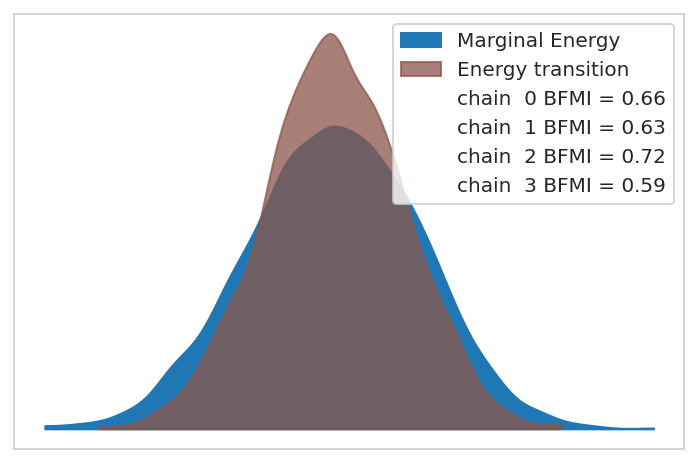

In [16]:
az.plot_energy(trace);

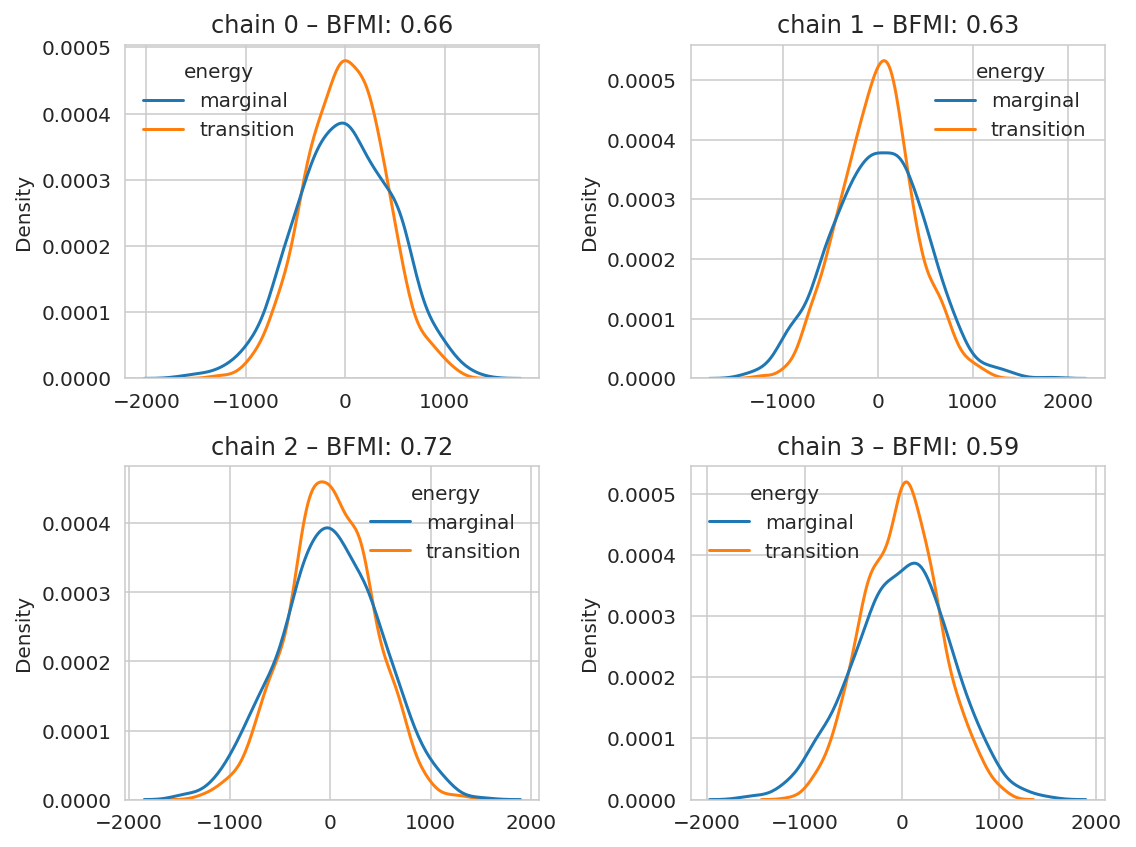

In [17]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

In [18]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size  n_steps  tree_depth  acceptance_rate        energy
chain                                                               
0       0.013858  255.000       8.000         0.968338  1.028328e+07
1       0.011998  511.000       9.000         0.977313  1.028330e+07
2       0.012291  511.000       9.000         0.975199  1.028331e+07
3       0.012576  510.232       8.997         0.972944  1.028327e+07

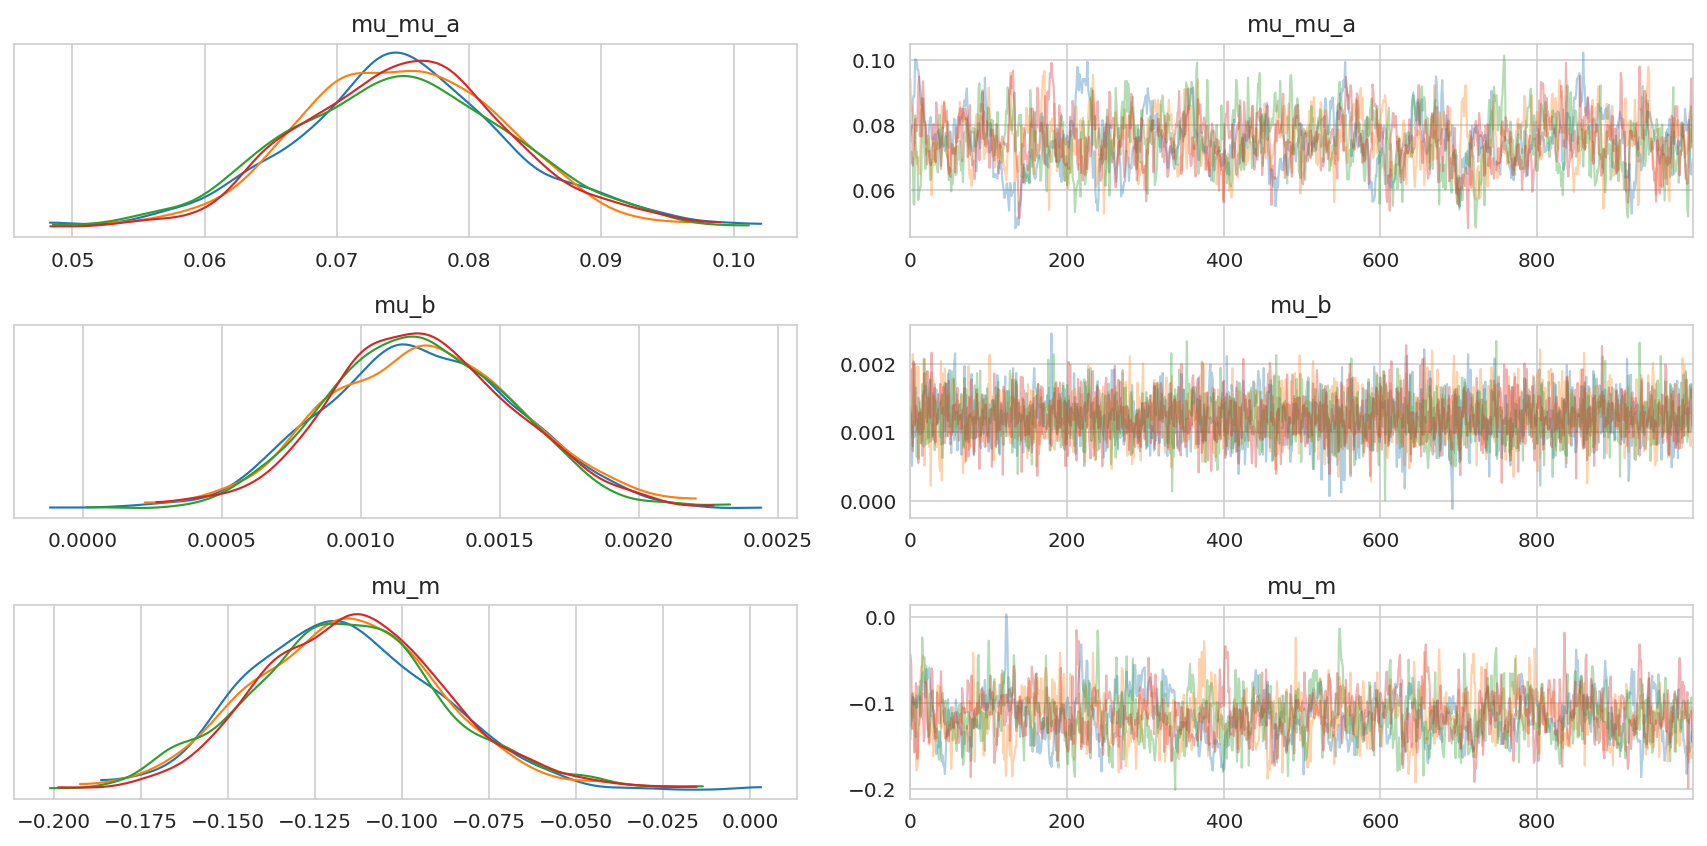

In [19]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_m"], compact=False)
plt.tight_layout()

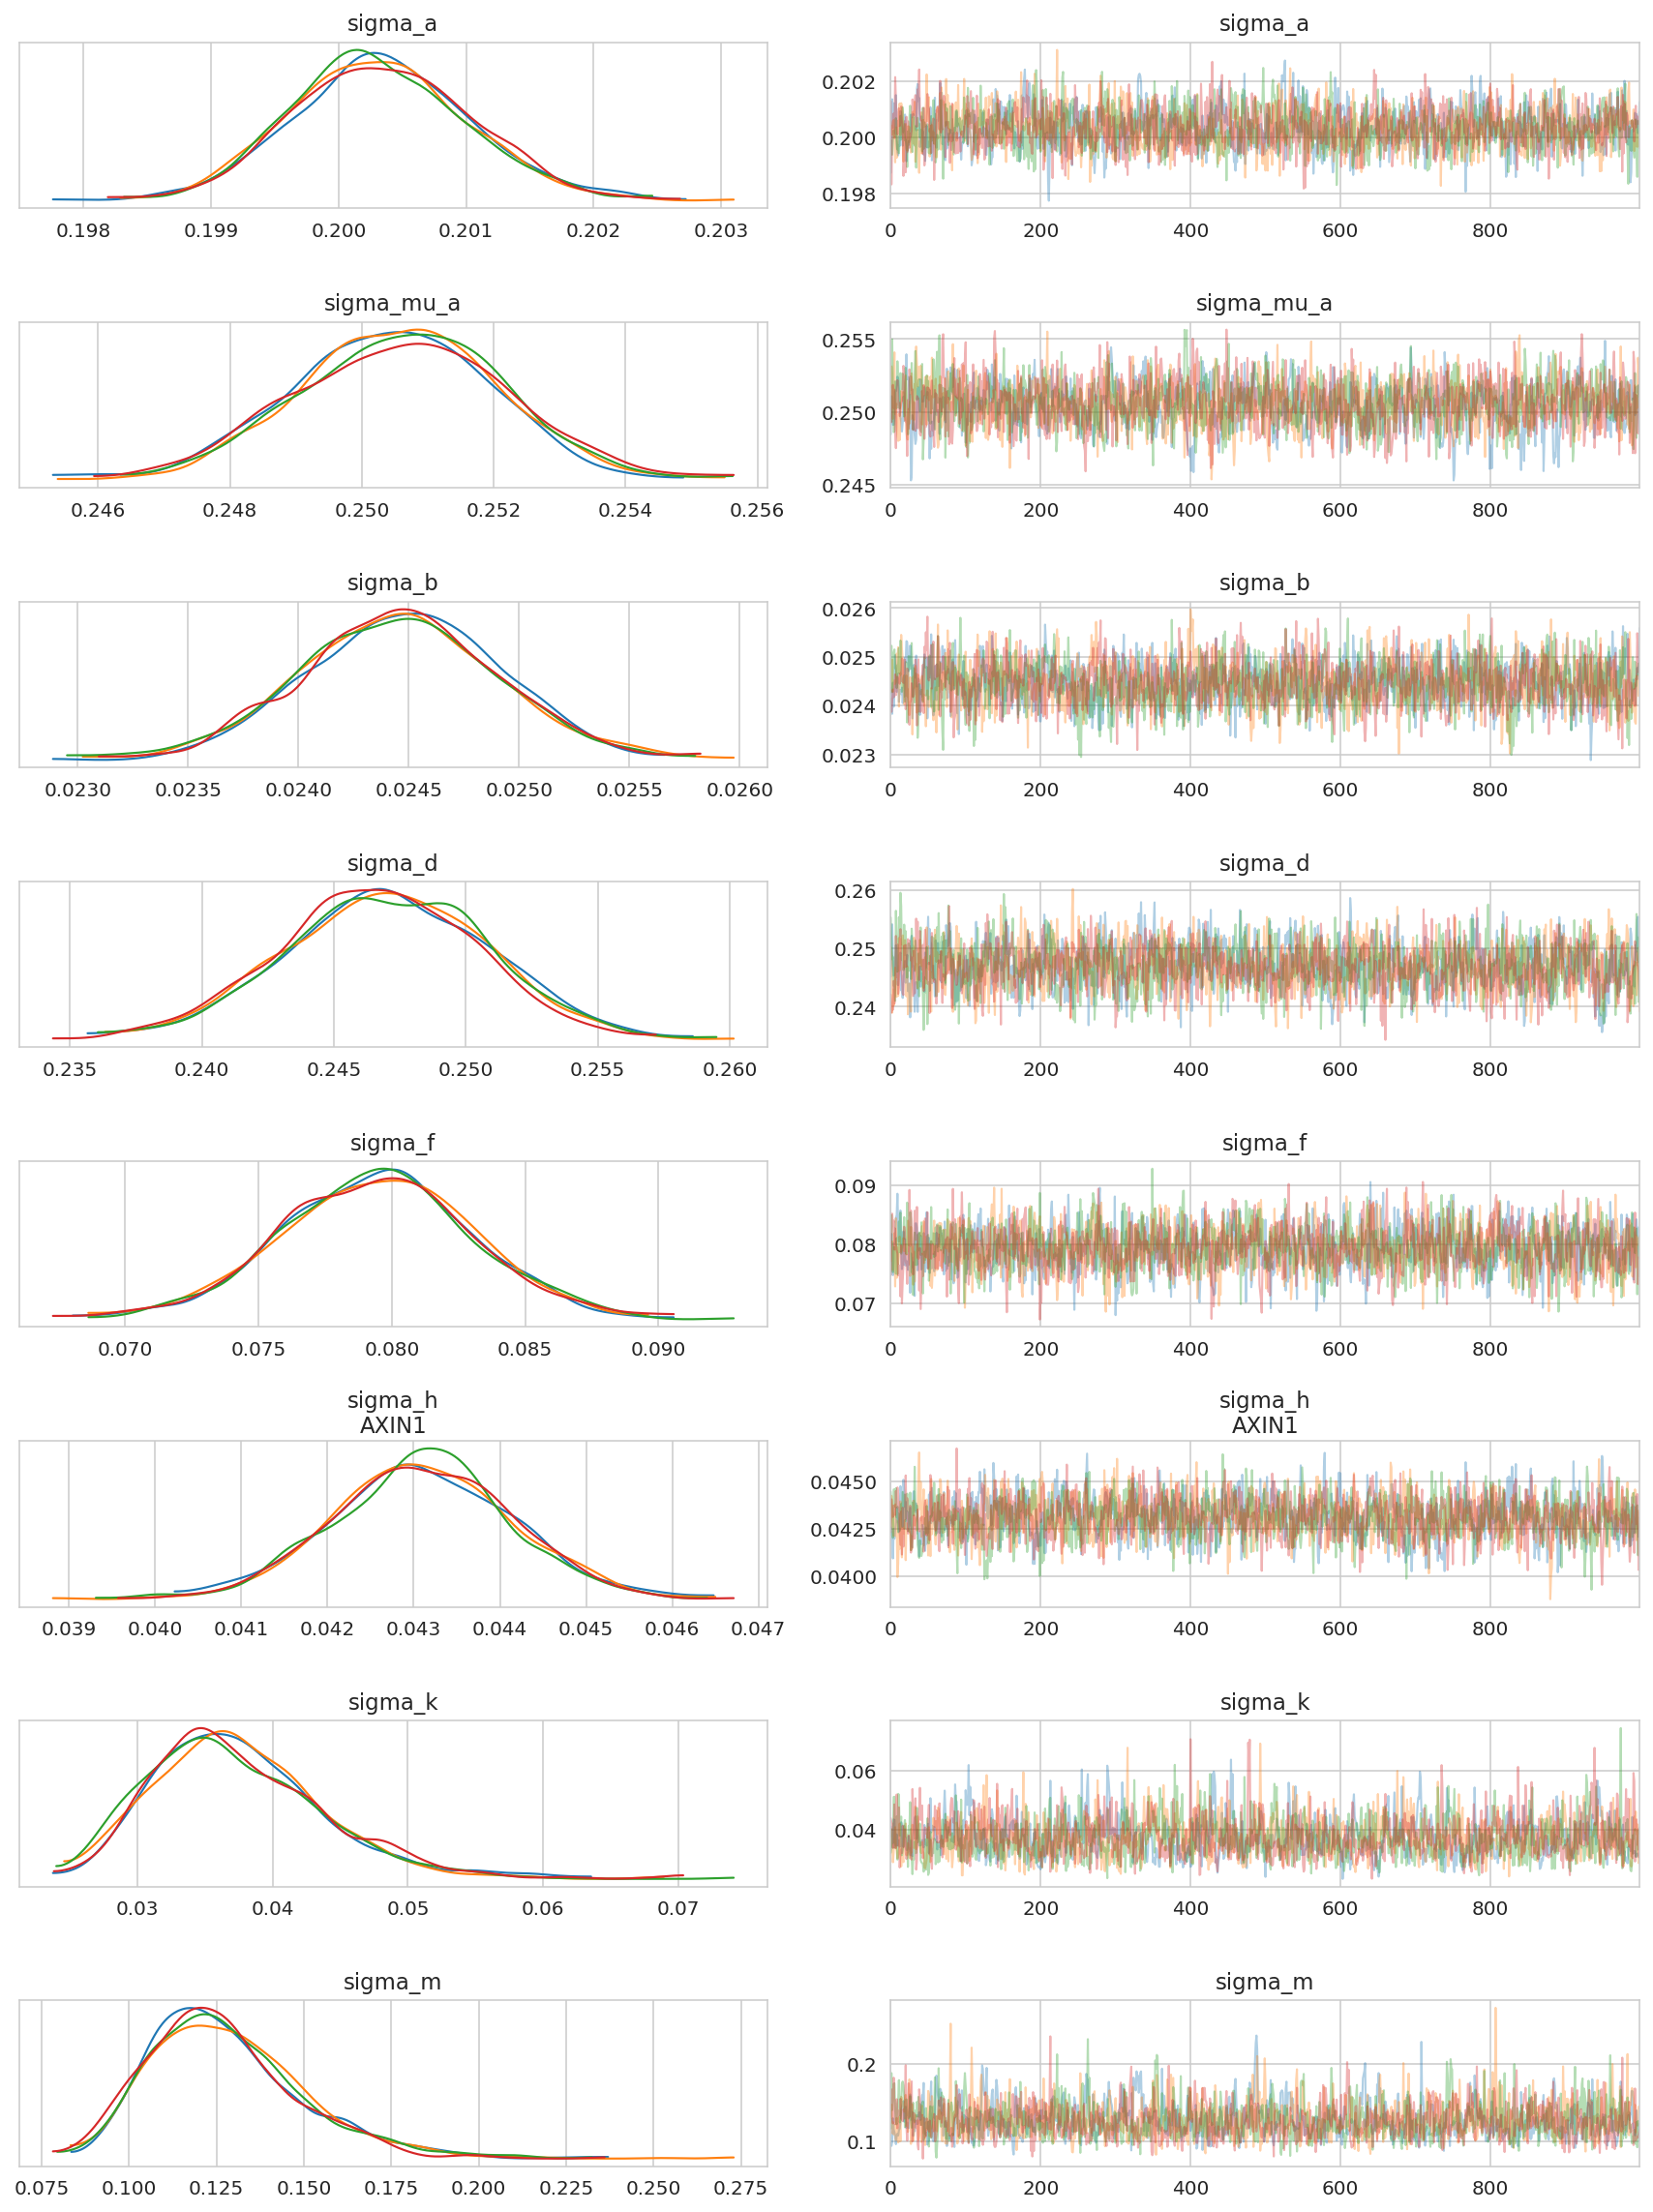

In [20]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [21]:
az.summary(trace, var_names=["^sigma_.*$"], filter_vars="regex")

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
sigma_a         0.200  0.001     0.199      0.201      0.000      0.0   
sigma_mu_a      0.251  0.002     0.248      0.253      0.000      0.0   
sigma_b         0.024  0.000     0.024      0.025      0.000      0.0   
sigma_d         0.247  0.004     0.241      0.253      0.000      0.0   
sigma_f         0.079  0.004     0.074      0.085      0.000      0.0   
sigma_h[AXIN1]  0.043  0.001     0.041      0.045      0.000      0.0   
sigma_k         0.037  0.006     0.027      0.047      0.000      0.0   
sigma_m         0.128  0.022     0.093      0.159      0.001      0.0   

                ess_bulk  ess_tail  r_hat  
sigma_a           1351.0    2085.0    1.0  
sigma_mu_a        1496.0    1761.0    1.0  
sigma_b           1559.0    2580.0    1.0  
sigma_d           1316.0    2110.0    1.0  
sigma_f           1748.0    2365.0    1.0  
sigma_h[AXIN1]    1429.0    2244.0    1.0  
sigma_k           1060.0    2203.0    1.0  
sigma_m           1280.0    1863.0    1.0

In [22]:
sigmas = ["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_k"]
trace.posterior.get(sigmas).mean(dim="draw").to_dataframe()

sigma_mu_a   sigma_b   sigma_d   sigma_f   sigma_k
chain                                                    
0        0.250388  0.024486  0.247099  0.079376  0.037614
1        0.250589  0.024462  0.246935  0.079434  0.037399
2        0.250645  0.024438  0.247067  0.079448  0.036982
3        0.250606  0.024468  0.246565  0.079338  0.037708

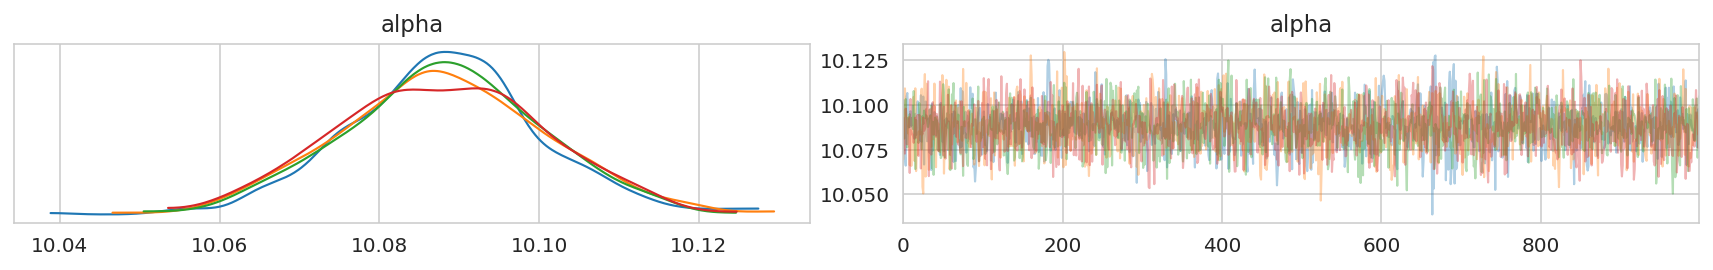

In [23]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

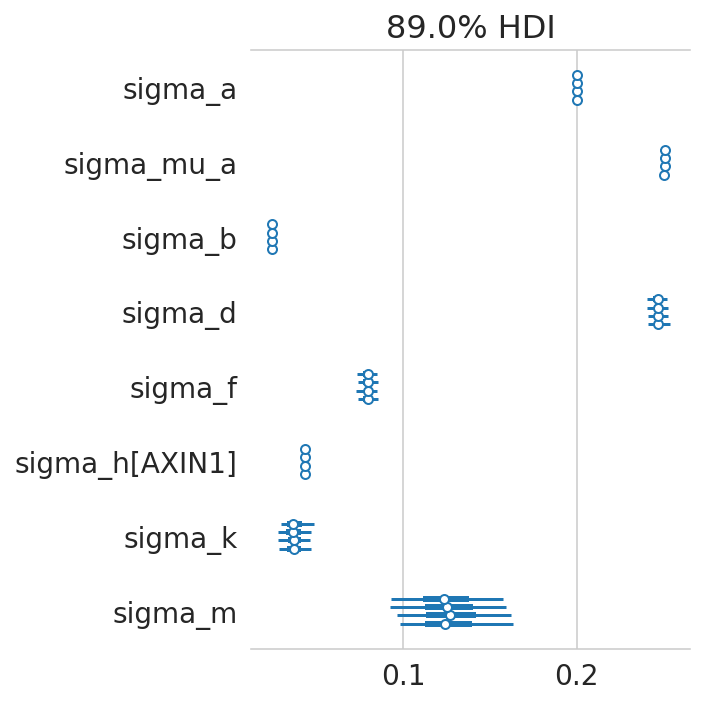

In [24]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

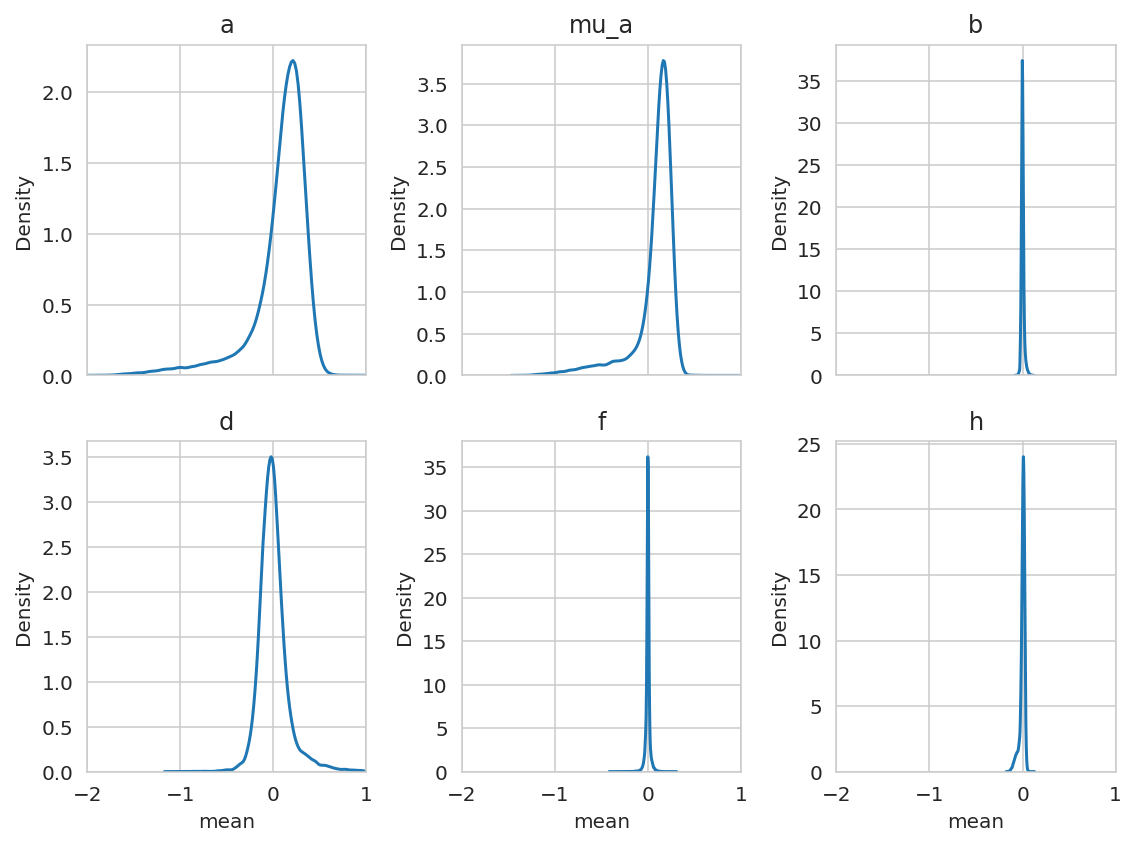

In [25]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = liver_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [26]:
sgrna_to_gene_map = (
    liver_data.copy()[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)

In [27]:
for v in ["mu_a", "b", "d", "f", "h", "k", "m"]:
    display(Markdown(f"variable: **{v}**"))
    top = (
        liver_post_summary.query(f"var_name == '{v}'")
        .sort_values("mean")
        .pipe(head_tail, 5)
    )
    display(top)

variable: **mu_a**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
2613    mu_a[CDC45] -1.373  0.097    -1.522     -1.213      0.002    0.001   
16654  mu_a[TXNL4A] -1.348  0.095    -1.497     -1.192      0.002    0.001   
13297   mu_a[RPS3A] -1.329  0.096    -1.476     -1.175      0.002    0.001   
13209   mu_a[RPL12] -1.311  0.096    -1.474     -1.165      0.002    0.001   
13314    mu_a[RPSA] -1.270  0.096    -1.417     -1.110      0.002    0.001   
9963      mu_a[NF2]  0.481  0.093     0.331      0.624      0.002    0.001   
16213    mu_a[TP53]  0.485  0.103     0.312      0.641      0.002    0.001   
17897  mu_a[ZNF611]  0.505  0.098     0.352      0.661      0.002    0.001   
7729    mu_a[KEAP1]  0.543  0.095     0.385      0.687      0.002    0.001   
12361    mu_a[PTEN]  0.880  0.096     0.730      1.039      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
2613     2116.0    1970.0    1.0     mu_a  
16654    2659.0    2882.0    1.0     mu_a  
13297    2928.0    2933.0    1.0     mu_a  
13209    2590.0    2789.0    1.0     mu_a  
13314    2307.0    2599.0    1.0     mu_a  
9963     2883.0    2997.0    1.0     mu_a  
16213    2493.0    2694.0    1.0     mu_a  
17897    2225.0    2481.0    1.0     mu_a  
7729     2251.0    2661.0    1.0     mu_a  
12361    2355.0    2933.0    1.0     mu_a

variable: **b**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
25817    b[KCTD5] -0.078  0.018    -0.108     -0.050        0.0      0.0   
24926    b[HNF1B] -0.076  0.020    -0.105     -0.042        0.0      0.0   
26589   b[LRPPRC] -0.072  0.020    -0.106     -0.041        0.0      0.0   
35633  b[ZFP36L1] -0.071  0.020    -0.103     -0.040        0.0      0.0   
23554     b[FGF4] -0.069  0.021    -0.103     -0.035        0.0      0.0   
24087    b[GINS2]  0.108  0.019     0.077      0.138        0.0      0.0   
34773   b[TXNL4A]  0.110  0.021     0.080      0.145        0.0      0.0   
30443    b[PSMD7]  0.112  0.020     0.082      0.144        0.0      0.0   
35479     b[YRDC]  0.115  0.020     0.083      0.147        0.0      0.0   
27482   b[MRPL33]  0.121  0.020     0.089      0.153        0.0      0.0   

       ess_bulk  ess_tail  r_hat var_name  
25817    7382.0    3302.0    1.0        b  
24926    7304.0    2929.0    1.0        b  
26589    7722.0    3234.0    1.0        b  
35633    6594.0    3362.0    1.0        b  
23554    6982.0    3175.0    1.0        b  
24087    7162.0    2867.0    1.0        b  
34773    5950.0    2953.0    1.0        b  
30443    7100.0    2665.0    1.0        b  
35479    7142.0    2538.0    1.0        b  
27482    6734.0    2917.0    1.0        b

variable: **d**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
38686  d[CCND1] -1.101  0.091    -1.244     -0.953      0.001    0.001   
53569  d[YARS2] -0.950  0.180    -1.238     -0.663      0.002    0.002   
43045  d[HNF1B] -0.865  0.176    -1.146     -0.580      0.002    0.002   
43936  d[KCTD5] -0.857  0.188    -1.148     -0.545      0.002    0.002   
41666  d[FGF19] -0.847  0.080    -0.975     -0.722      0.001    0.001   
44022  d[KIF11]  1.154  0.201     0.843      1.490      0.002    0.002   
38894  d[CDIPT]  1.167  0.190     0.861      1.466      0.002    0.002   
48704   d[PWP2]  1.225  0.169     0.959      1.495      0.002    0.002   
50860   d[SOD1]  1.241  0.189     0.952      1.553      0.002    0.002   
50709   d[SMG1]  1.241  0.172     0.965      1.505      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
38686    5893.0    3024.0    1.0        d  
53569    6548.0    3008.0    1.0        d  
43045    6196.0    3076.0    1.0        d  
43936    6992.0    3331.0    1.0        d  
41666    5349.0    3537.0    1.0        d  
44022    6534.0    2987.0    1.0        d  
38894    6682.0    3097.0    1.0        d  
48704    5925.0    2836.0    1.0        d  
50860    7776.0    3333.0    1.0        d  
50709    6896.0    2933.0    1.0        d

variable: **f**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
70570      f[TP53] -0.407  0.058    -0.493     -0.312      0.001    0.001   
57994    f[CTNNB1] -0.268  0.080    -0.381     -0.127      0.001    0.001   
55931      f[BOP1] -0.213  0.067    -0.325     -0.112      0.001    0.001   
66210    f[POLRMT] -0.207  0.061    -0.303     -0.106      0.001    0.001   
70549     f[TONSL] -0.201  0.079    -0.338     -0.087      0.001    0.001   
59220       f[ERH]  0.145  0.070     0.034      0.258      0.001    0.001   
61092  f[HIST2H3D]  0.152  0.071     0.034      0.264      0.001    0.001   
60905     f[HCFC1]  0.174  0.069     0.067      0.286      0.001    0.001   
64287     f[NELFB]  0.217  0.069     0.105      0.324      0.001    0.001   
54966    f[AMBRA1]  0.300  0.068     0.194      0.411      0.001    0.001   

       ess_bulk  ess_tail  r_hat var_name  
70570    5594.0    3391.0    1.0        f  
57994    6077.0    2912.0    1.0        f  
55931    6630.0    2832.0    1.0        f  
66210    6542.0    2989.0    1.0        f  
70549    6871.0    2998.0    1.0        f  
59220    5758.0    3017.0    1.0        f  
61092    6810.0    2951.0    1.0        f  
60905    7233.0    3060.0    1.0        f  
64287    6301.0    2830.0    1.0        f  
54966    5164.0    2648.0    1.0        f

variable: **h**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
151499      h[KPNB1, AXIN1] -0.165  0.033    -0.215     -0.111      0.000   
158396      h[SRBD1, AXIN1] -0.152  0.034    -0.204     -0.097      0.000   
146429     h[CHAF1B, AXIN1] -0.151  0.033    -0.206     -0.098      0.000   
146151      h[CDC45, AXIN1] -0.150  0.034    -0.202     -0.094      0.000   
160136       h[TUBB, AXIN1] -0.144  0.034    -0.198     -0.090      0.000   
150352  h[HNRNPA2B1, AXIN1]  0.062  0.033     0.008      0.111      0.000   
147501      h[DDX3X, AXIN1]  0.062  0.033     0.011      0.115      0.000   
149125      h[FOXK1, AXIN1]  0.064  0.032     0.015      0.119      0.000   
144147     h[AMBRA1, AXIN1]  0.091  0.034     0.037      0.146      0.001   
159994       h[TSC2, AXIN1]  0.118  0.034     0.062      0.171      0.000   

        mcse_sd  ess_bulk  ess_tail  r_hat var_name  
151499      0.0    6690.0    2977.0    1.0        h  
158396      0.0    6853.0    3355.0    1.0        h  
146429      0.0    6138.0    2814.0    1.0        h  
146151      0.0    6419.0    2535.0    1.0        h  
160136      0.0    6585.0    2861.0    1.0        h  
150352      0.0    6572.0    2813.0    1.0        h  
147501      0.0    6517.0    2622.0    1.0        h  
149125      0.0    6035.0    2857.0    1.0        h  
144147      0.0    3670.0    3082.0    1.0        h  
159994      0.0    7160.0    3011.0    1.0        h

variable: **k**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
161676  k[ACH-000471] -0.119  0.008    -0.132     -0.106        0.0      0.0   
161677  k[ACH-000475] -0.041  0.008    -0.054     -0.029        0.0      0.0   
161687  k[ACH-000734] -0.031  0.008    -0.044     -0.018        0.0      0.0   
161685  k[ACH-000620] -0.020  0.008    -0.034     -0.008        0.0      0.0   
161675  k[ACH-000422] -0.014  0.008    -0.028     -0.003        0.0      0.0   
161680  k[ACH-000480]  0.025  0.008     0.012      0.038        0.0      0.0   
161688  k[ACH-000739]  0.030  0.008     0.017      0.042        0.0      0.0   
161681  k[ACH-000483]  0.034  0.008     0.021      0.046        0.0      0.0   
161674  k[ACH-000420]  0.039  0.008     0.026      0.052        0.0      0.0   
161684  k[ACH-000577]  0.048  0.008     0.035      0.061        0.0      0.0   

        ess_bulk  ess_tail  r_hat var_name  
161676     430.0     835.0    1.0        k  
161677     430.0     797.0    1.0        k  
161687     429.0     844.0    1.0        k  
161685     428.0     802.0    1.0        k  
161675     429.0     859.0    1.0        k  
161680     427.0     780.0    1.0        k  
161688     433.0     840.0    1.0        k  
161681     422.0     772.0    1.0        k  
161674     437.0     847.0    1.0        k  
161684     434.0     835.0    1.0        k

variable: **m**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
161694  m[ACH-000361] -0.404  0.011    -0.420     -0.384        0.0      0.0   
161709  m[ACH-000734] -0.303  0.009    -0.318     -0.289        0.0      0.0   
161710  m[ACH-000739] -0.281  0.010    -0.296     -0.265        0.0      0.0   
161699  m[ACH-000475] -0.271  0.008    -0.283     -0.257        0.0      0.0   
161707  m[ACH-000620] -0.203  0.009    -0.217     -0.188        0.0      0.0   
161712  m[ACH-001318] -0.047  0.011    -0.065     -0.030        0.0      0.0   
161703  m[ACH-000483] -0.004  0.008    -0.017      0.009        0.0      0.0   
161691  m[ACH-000217]  0.012  0.009    -0.001      0.028        0.0      0.0   
161697  m[ACH-000422]  0.022  0.009     0.008      0.037        0.0      0.0   
161693  m[ACH-000316]  0.081  0.011     0.064      0.098        0.0      0.0   

        ess_bulk  ess_tail  r_hat var_name  
161694    4437.0    3438.0    1.0        m  
161709    4085.0    3735.0    1.0        m  
161710    4120.0    4057.0    1.0        m  
161699    4311.0    3682.0    1.0        m  
161707    4421.0    3246.0    1.0        m  
161712    4355.0    3190.0    1.0        m  
161703    4095.0    3589.0    1.0        m  
161691    4249.0    3487.0    1.0        m  
161697    4230.0    3517.0    1.0        m  
161693    3728.0    3356.0    1.0        m

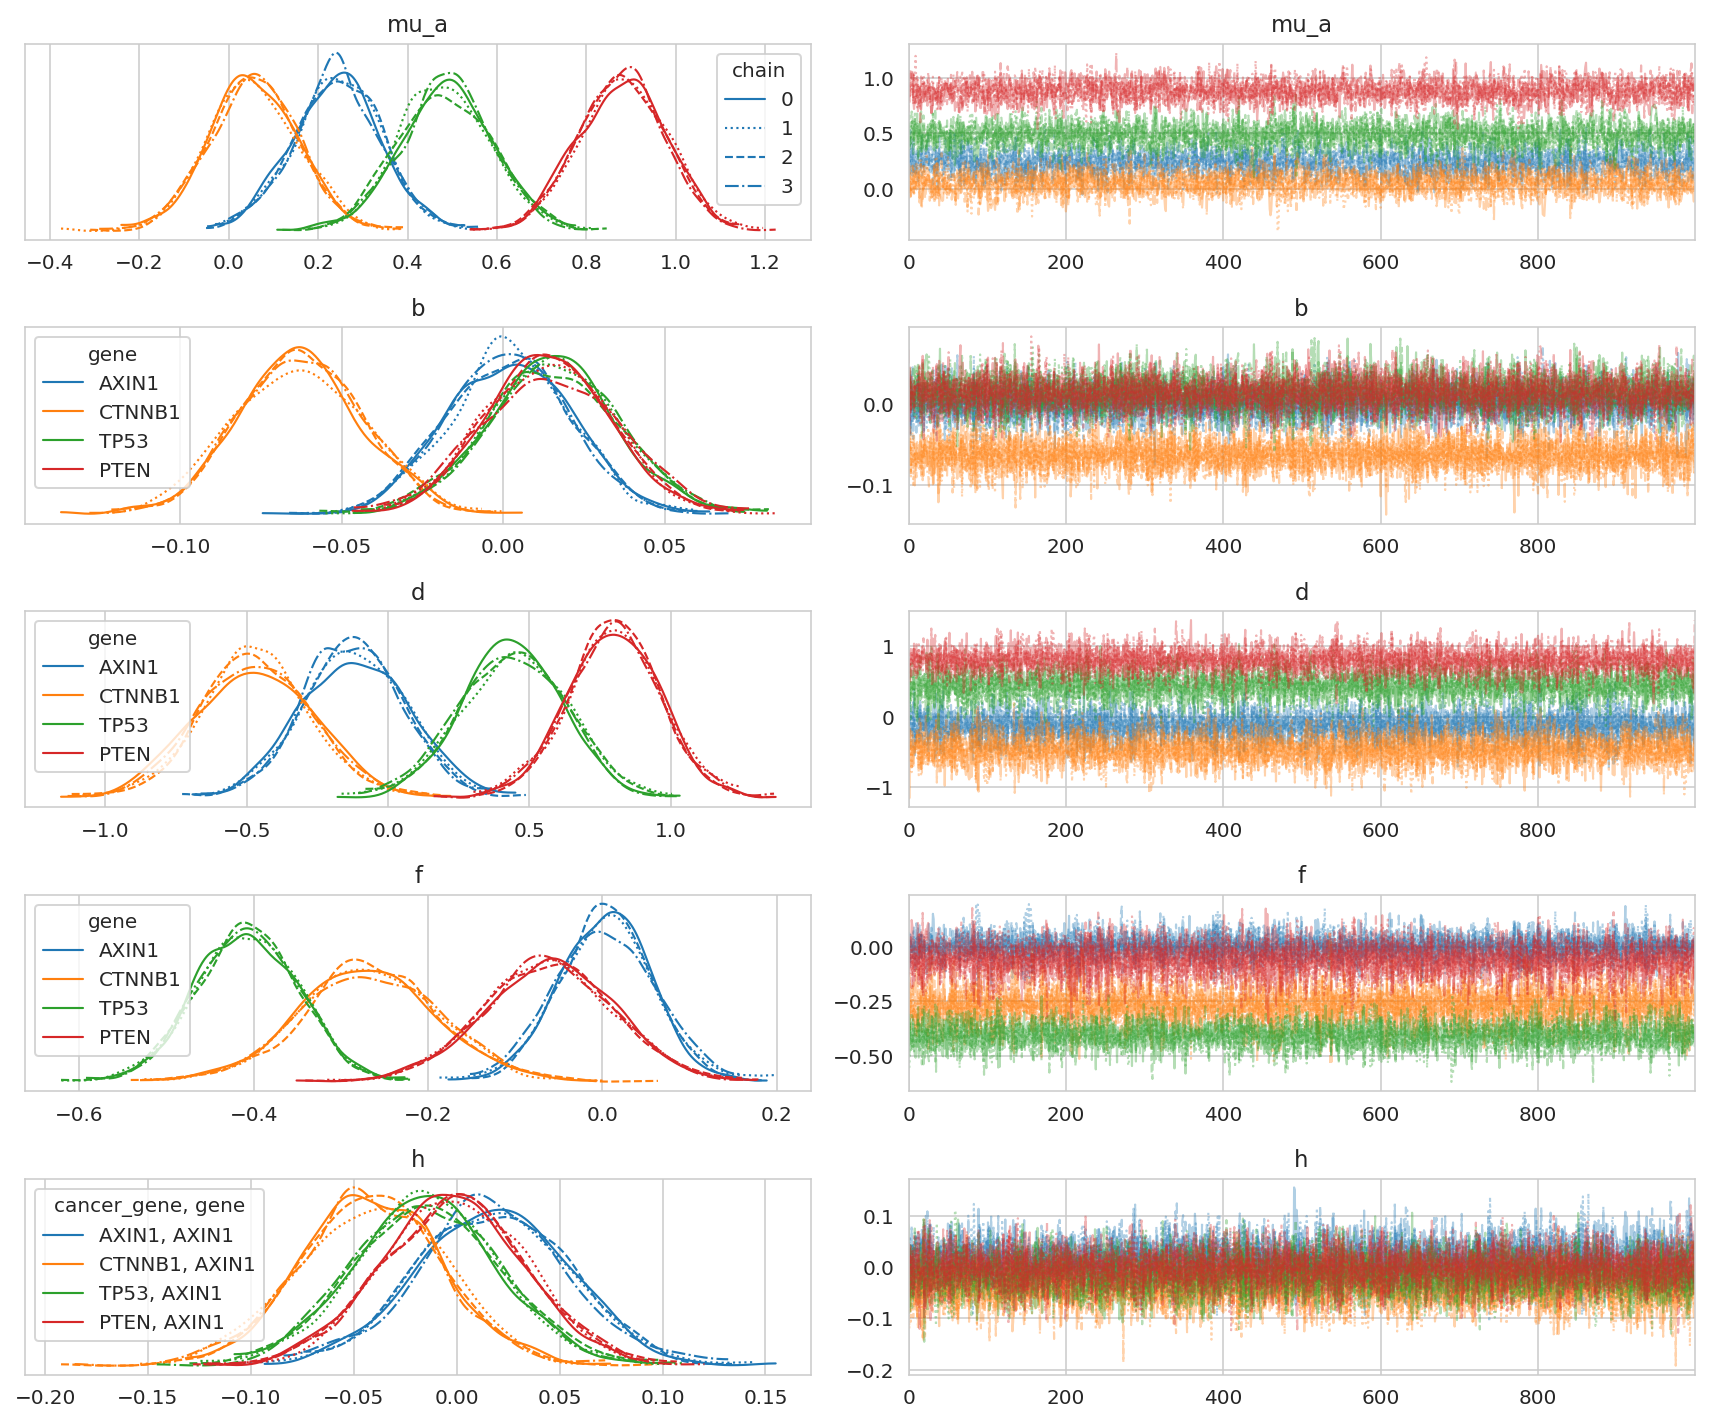

In [28]:
example_genes = ["AXIN1", "CTNNB1", "TP53", "PTEN"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=True,
    legend=True,
)
plt.tight_layout()
plt.show()

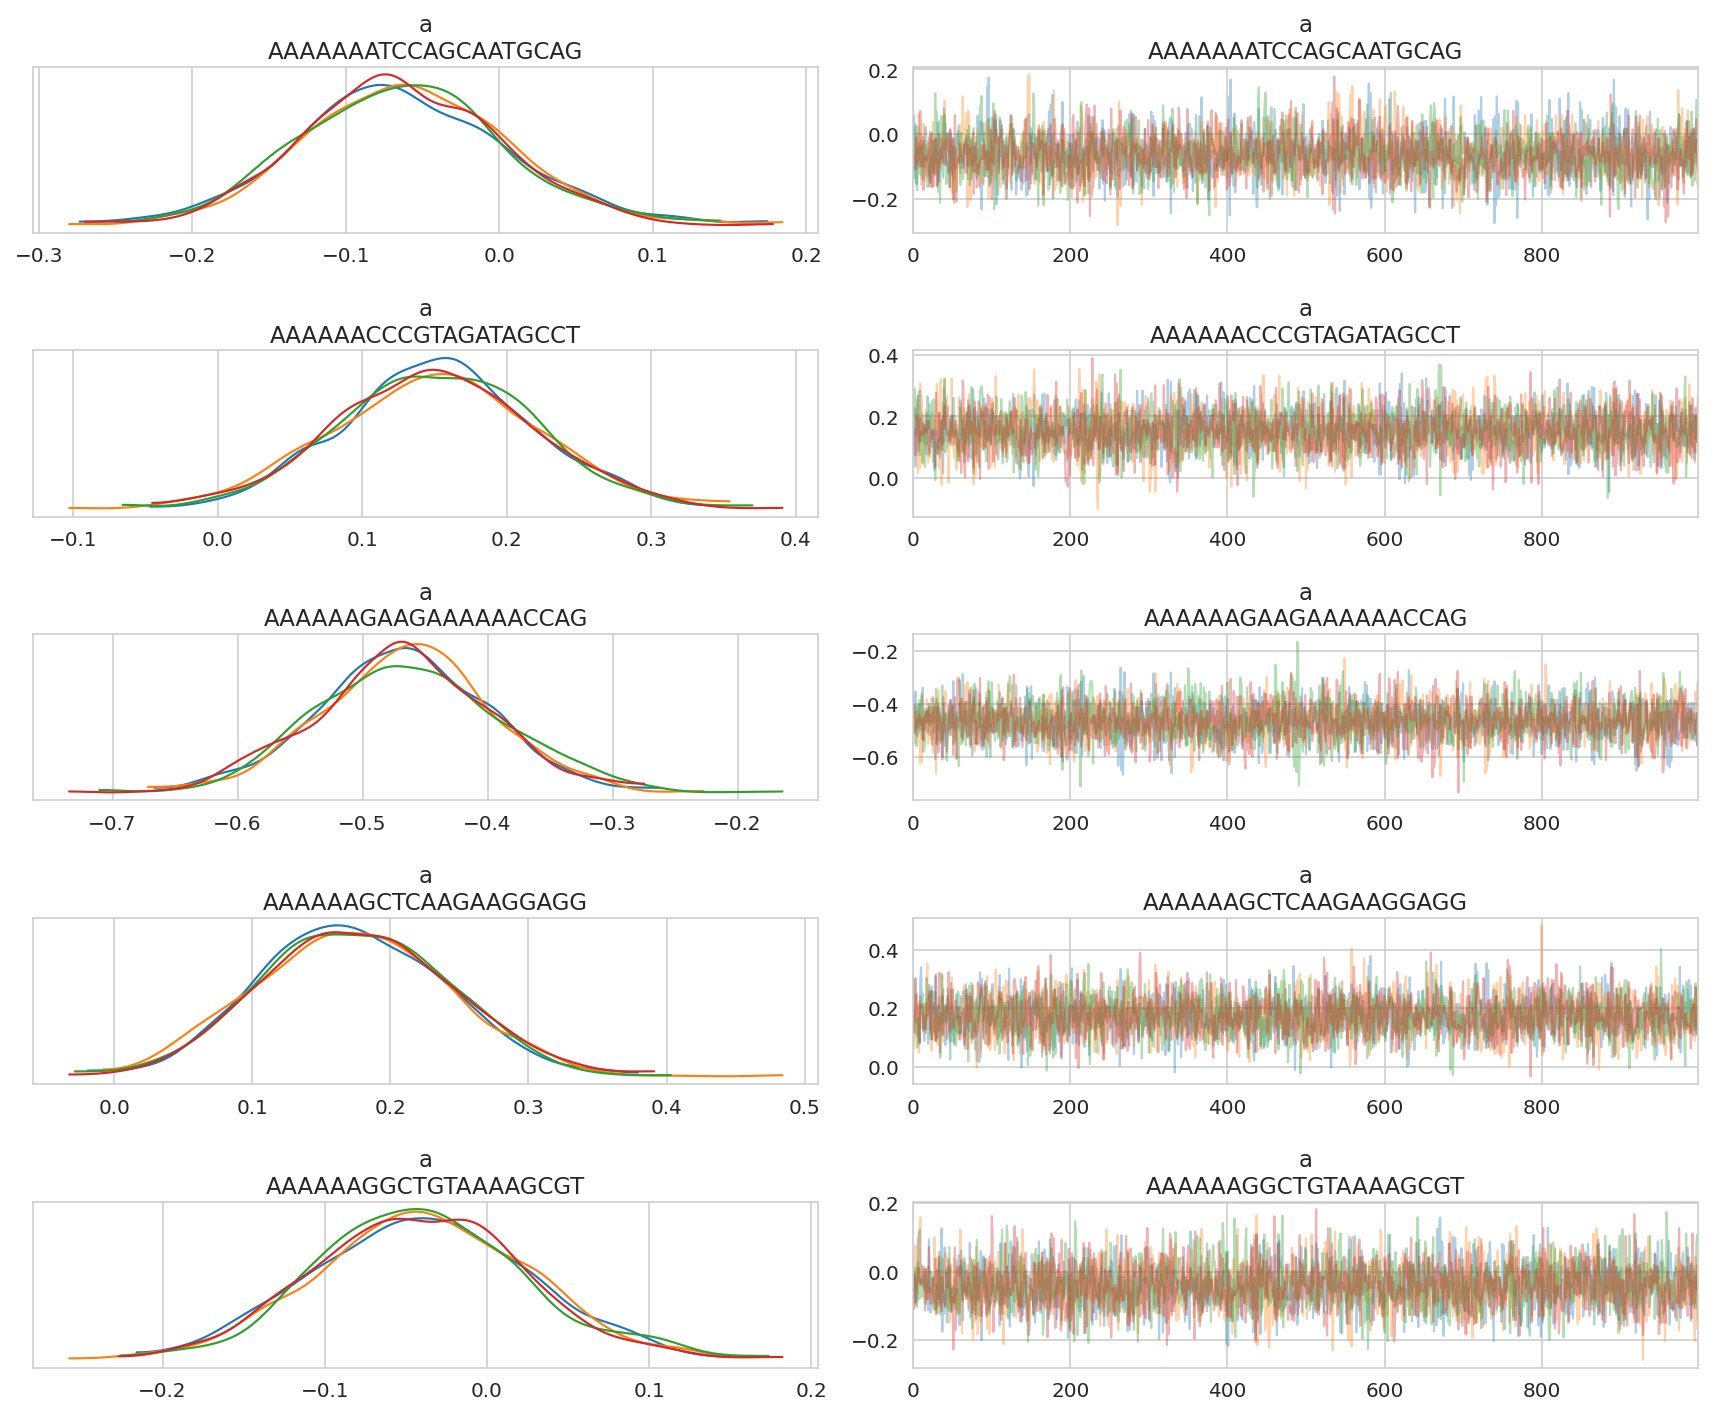

In [29]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

🧬 target gene: *AXIN1*

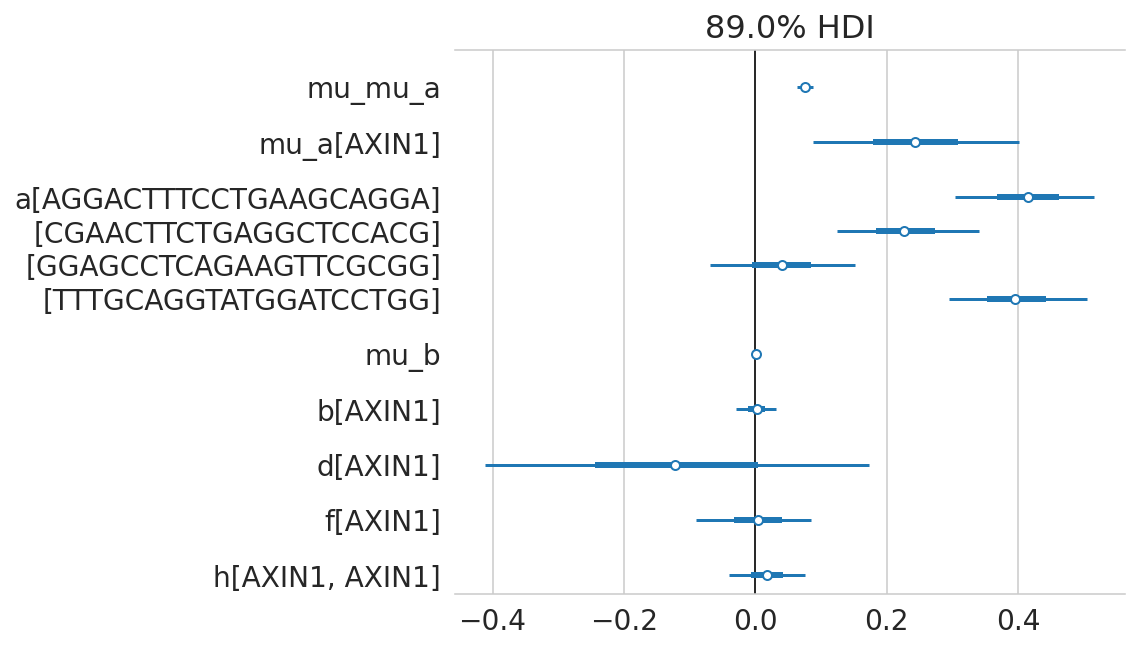

🧬 target gene: *CTNNB1*

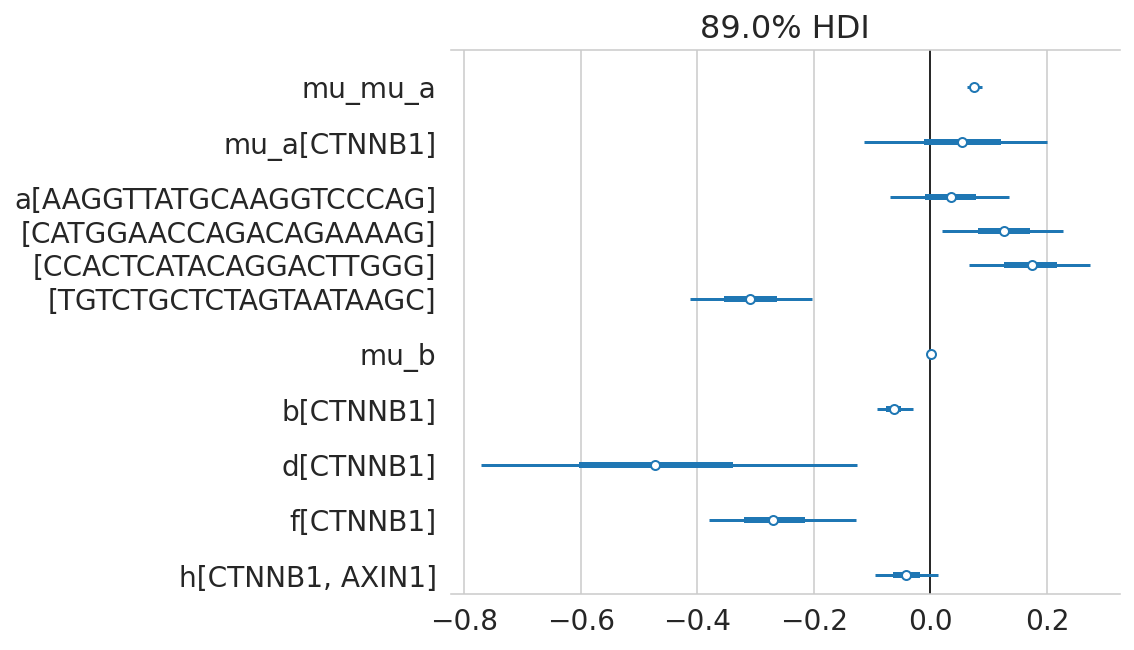

🧬 target gene: *TP53*

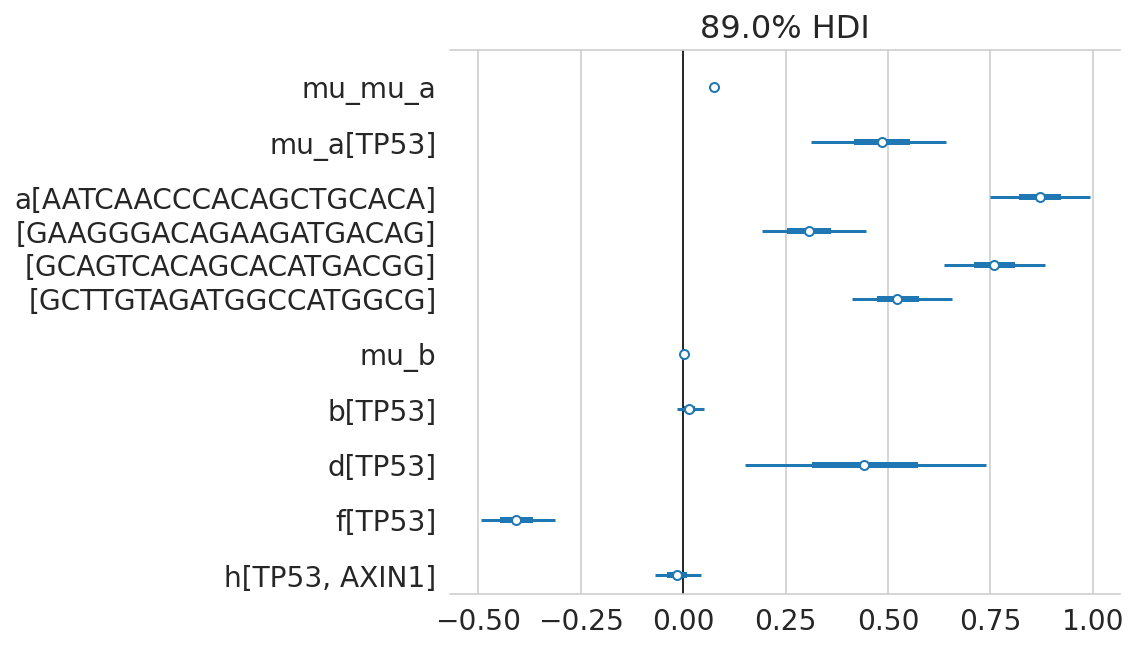

🧬 target gene: *PTEN*

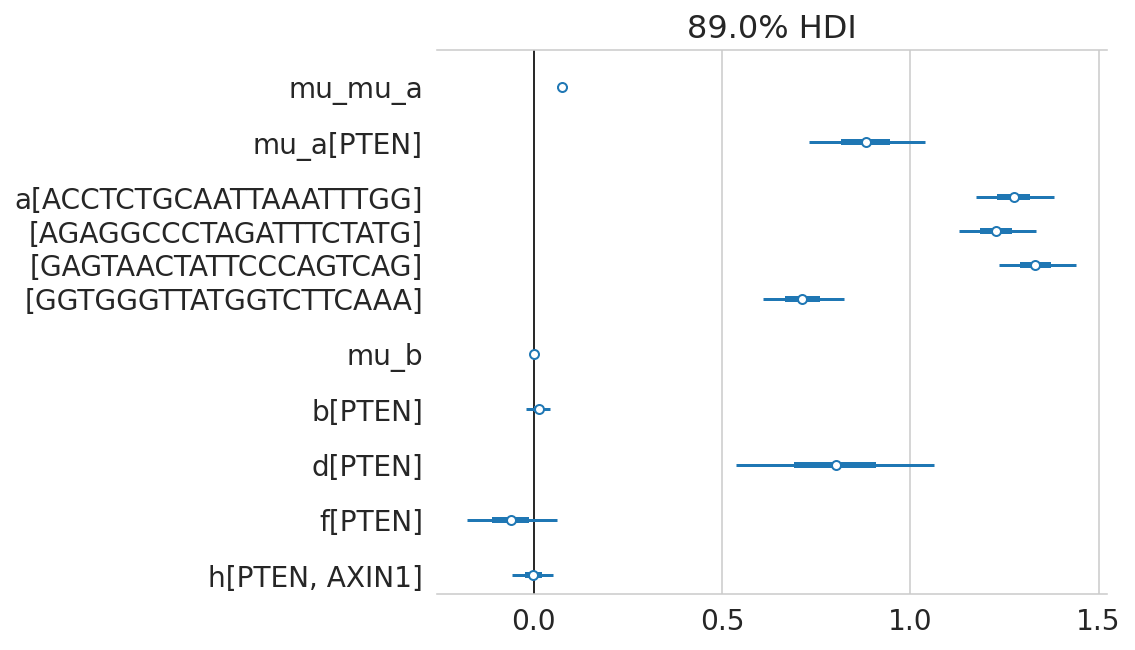

In [30]:
example_genes = ["AXIN1", "CTNNB1", "TP53", "PTEN"]
for example_gene in example_genes:
    display(Markdown(f"🧬 target gene: *{example_gene}*"))
    example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
        "sgrna"
    ].tolist()
    axes = az.plot_forest(
        trace,
        var_names=[
            "mu_mu_a",
            "mu_a",
            "a",
            "mu_b",
            "b",
            "d",
            "f",
            "h",
        ],
        coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
        combined=True,
        figsize=(6, 5),
    )
    axes[0].axvline(0, color="k", lw=0.8, zorder=1)
    plt.show()

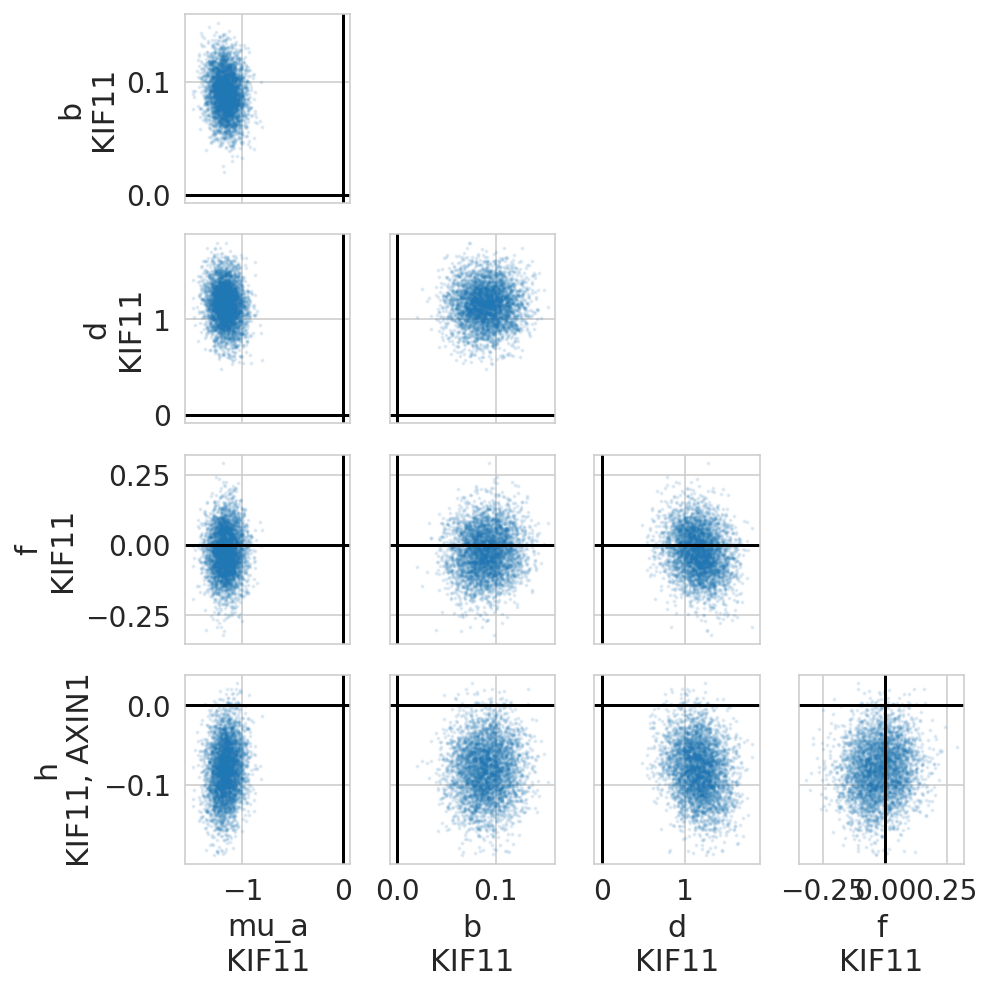

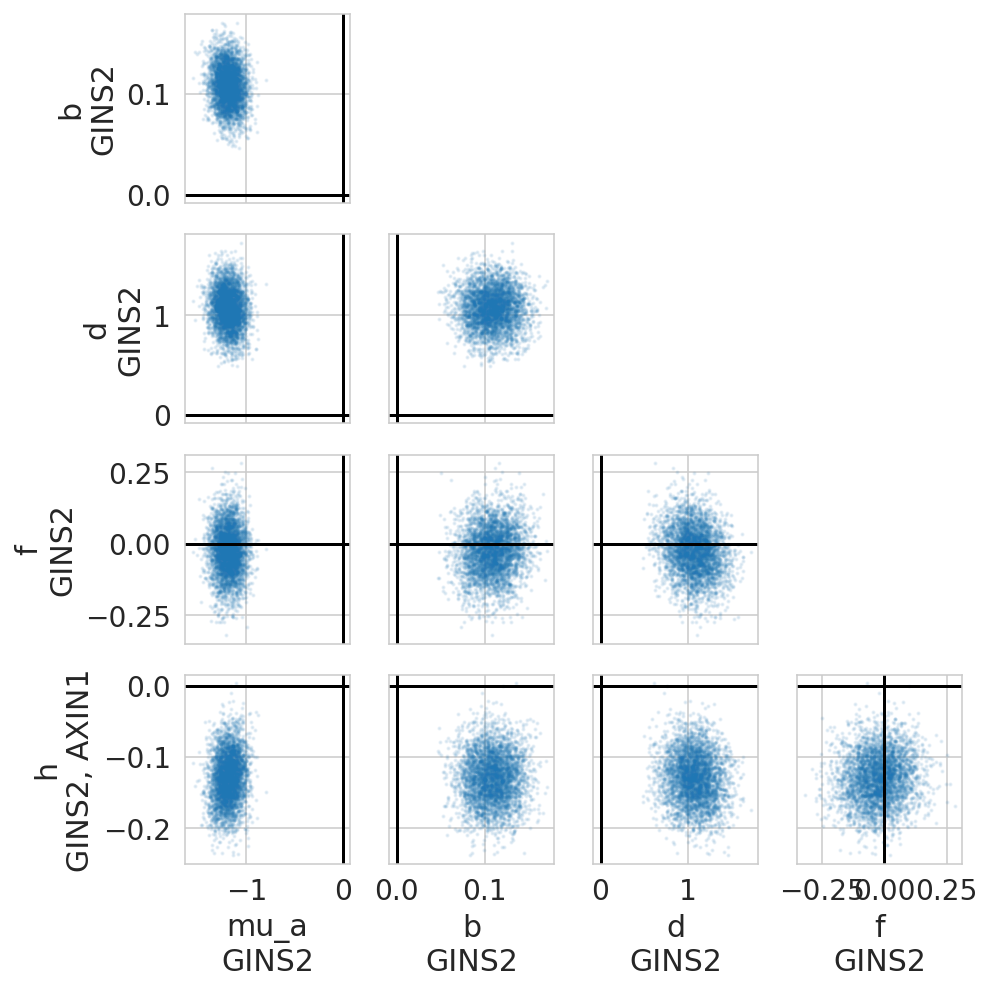

In [31]:
for gene in ["KIF11", "GINS2"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.1, "markersize": 2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

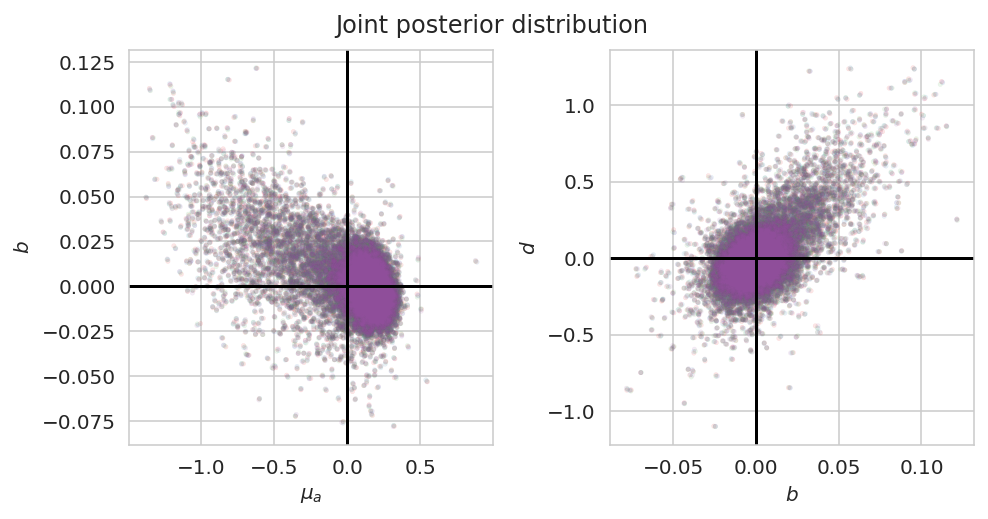

In [32]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

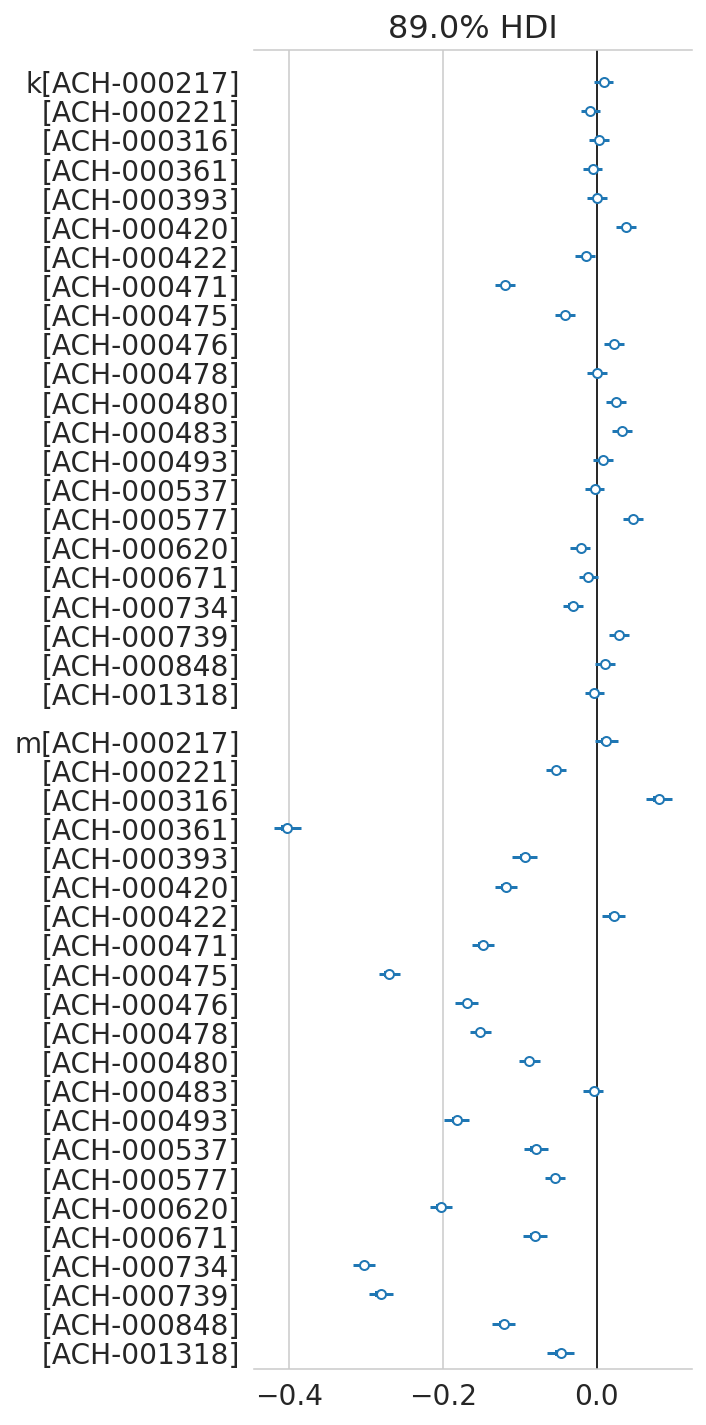

In [33]:
axes = az.plot_forest(trace, var_names=["k", "m"], combined=True, figsize=(5, 10))
axes[0].axvline(0, color="k", lw=0.8, zorder=1)
plt.tight_layout()
plt.show()

In [34]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)

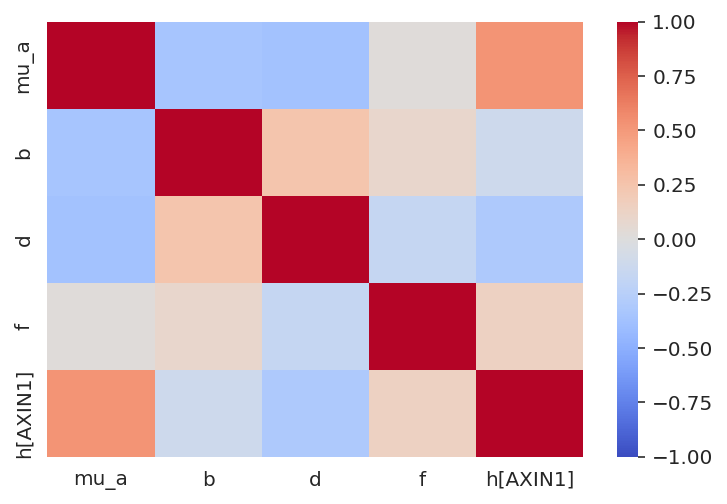

In [35]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
ax = sns.heatmap(
    plot_df,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
ax.set_ylabel(None)
plt.show()

In [36]:
cells_var_names = ["k", "m"]
cells_corr_post = (
    az.summary(trace, "cells_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [cells_var_names[i] for i in d["d1"]],
        p2=lambda d: [cells_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)

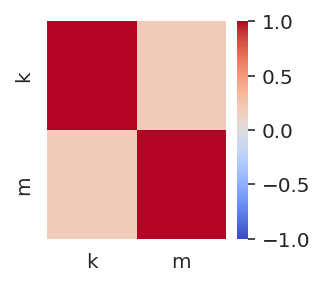

In [37]:
_, ax = plt.subplots(figsize=(2, 2))
plot_df = cells_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_ylabel(None)
plt.show()

In [38]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_liver_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

AXIN1
depmap_id       
ACH-000217     X
ACH-000221      
ACH-000316      
ACH-000361      
ACH-000393      
ACH-000420     X
ACH-000422      
ACH-000471      
ACH-000475     X
ACH-000476      
ACH-000478      
ACH-000480      
ACH-000483      
ACH-000493     X
ACH-000537      
ACH-000577      
ACH-000620      
ACH-000671      
ACH-000734     X
ACH-000739      
ACH-000848     X
ACH-001318

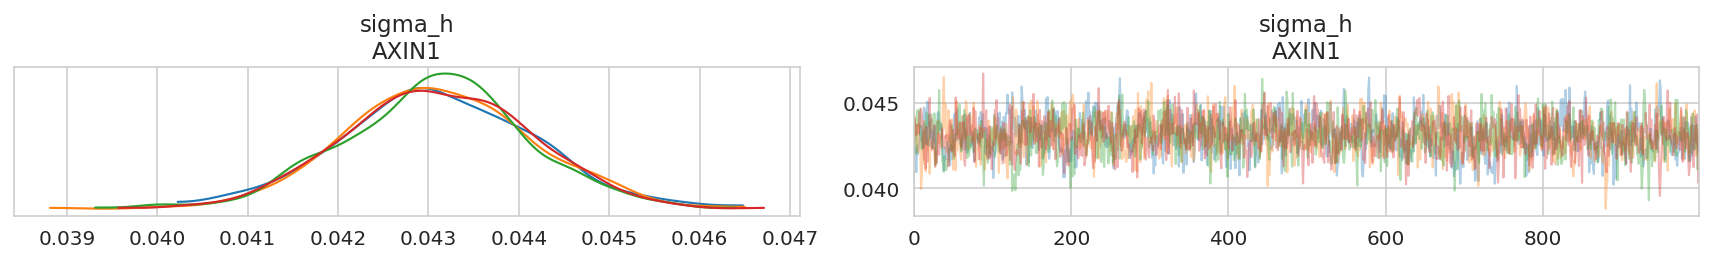

In [39]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

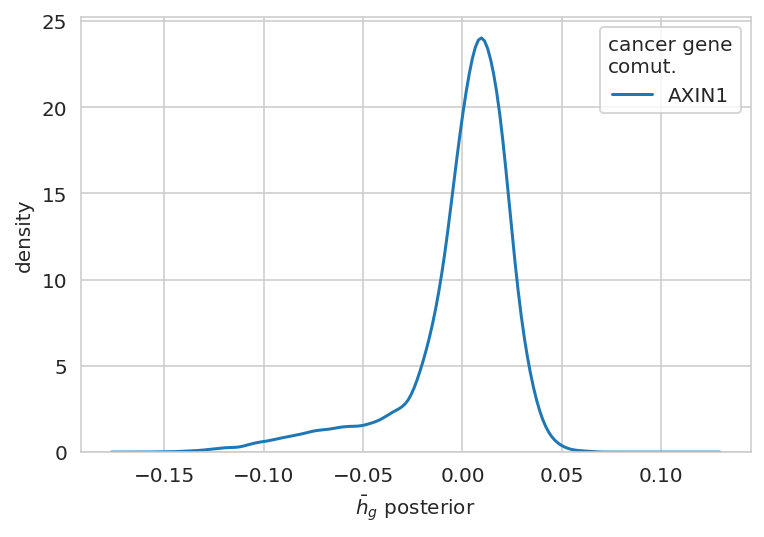

In [40]:
h_post_summary = (
    liver_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)

ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

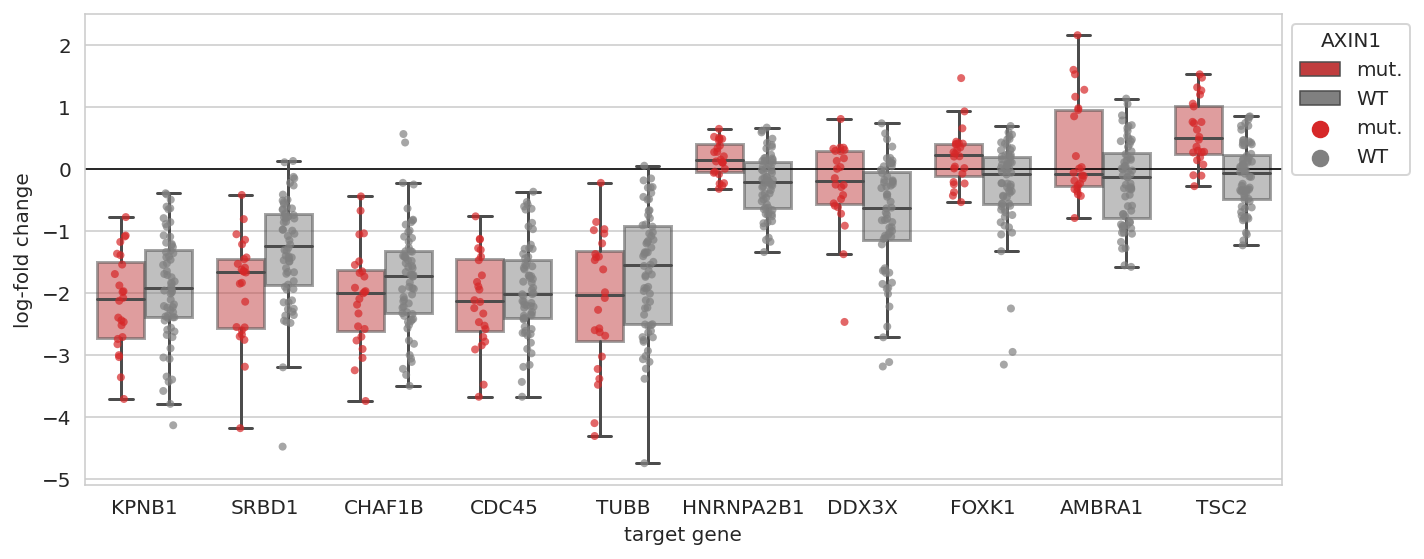

In [41]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(10, len(cancer_genes) * 4)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_liver_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    ax.axhline(0, color="k", lw=0.8)
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    boxes = sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    points = sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        s=4,
        alpha=0.7,
        ax=ax,
    )
    sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title=cg)
    ax.set_xlabel(None)
    ax.set_ylabel("log-fold change")

axes[-1, 0].set_xlabel("target gene")
plt.tight_layout()
plt.show()

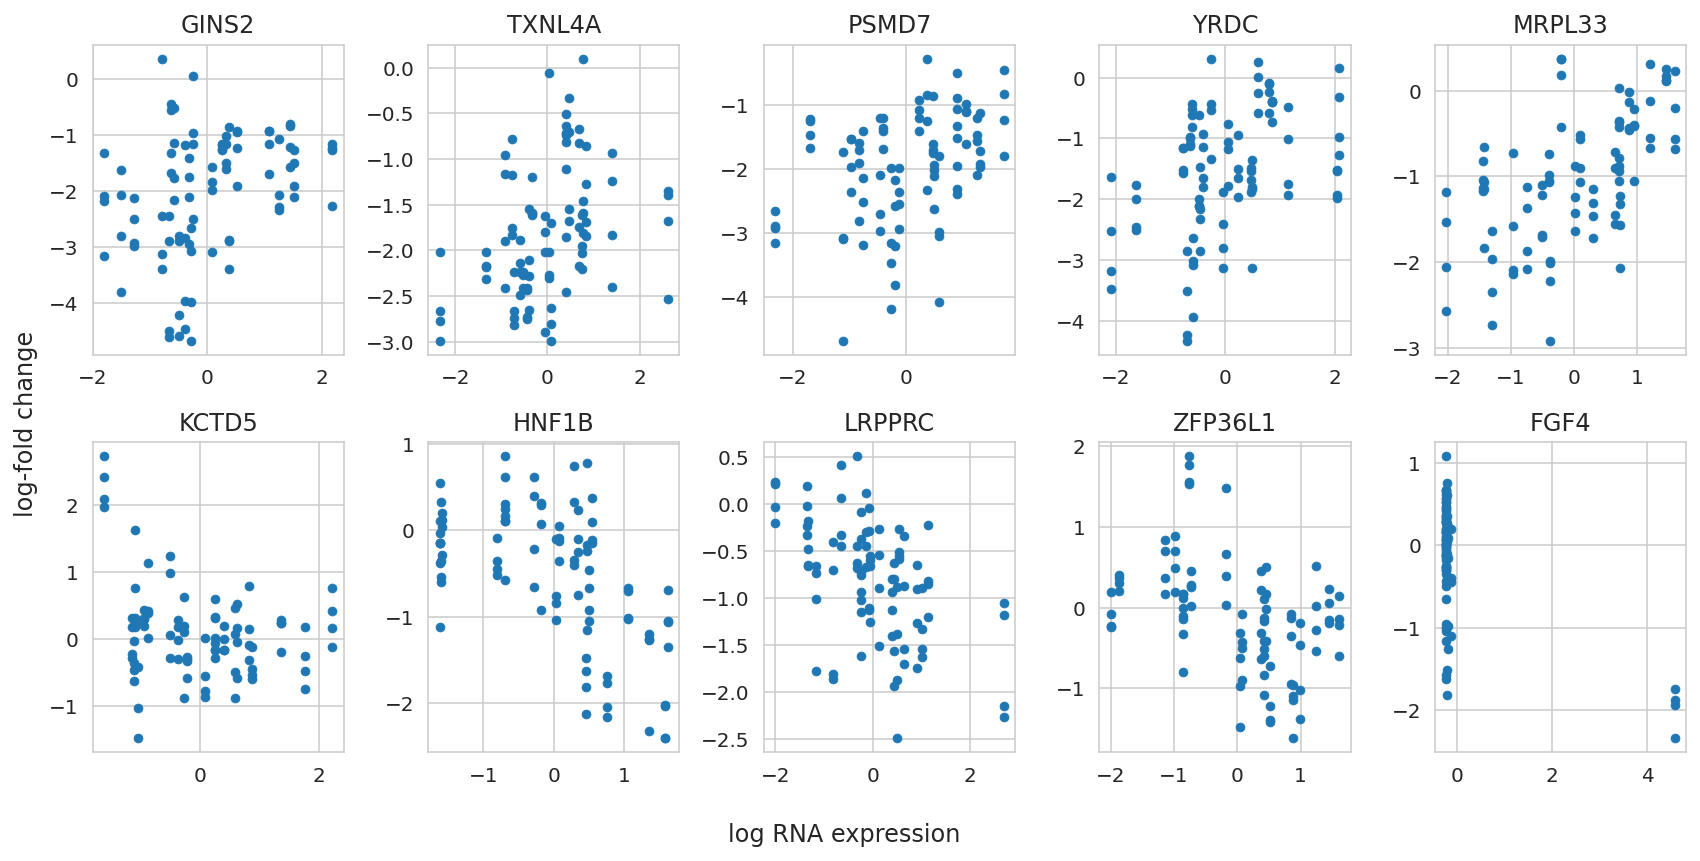

In [42]:
top_n = 5
top_b_hits = (
    liver_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_b = top_b_hits["hugo_symbol"][:top_n].values
positive_b = top_b_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_b, negative_b]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = valid_liver_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(
            data=obs_data, x="m_rna_gene", y="lfc", ax=ax, edgecolor=None, s=20
        )
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("log RNA expression")
fig.supylabel("log-fold change")

fig.tight_layout()
plt.show()

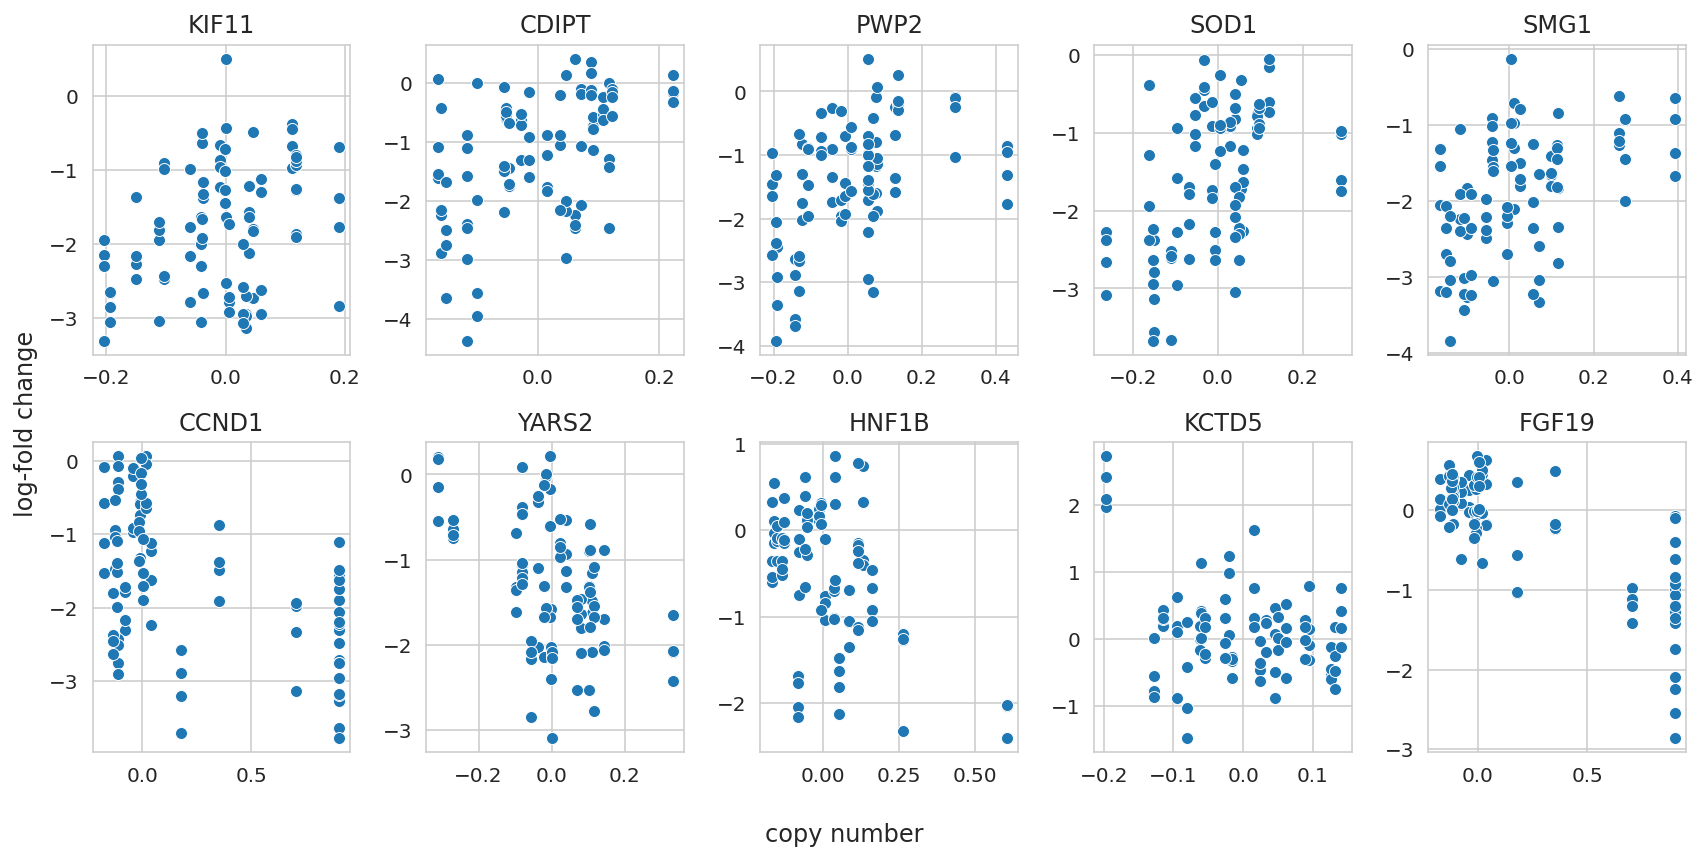

In [43]:
top_n = 5
top_d_hits = (
    liver_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_d = top_d_hits["hugo_symbol"][:top_n].values
positive_d = top_d_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_d, negative_d]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = valid_liver_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="cn_gene", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("copy number")
fig.supylabel("log-fold change")
fig.tight_layout()
plt.show()

## PPC

In [44]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 1563306)

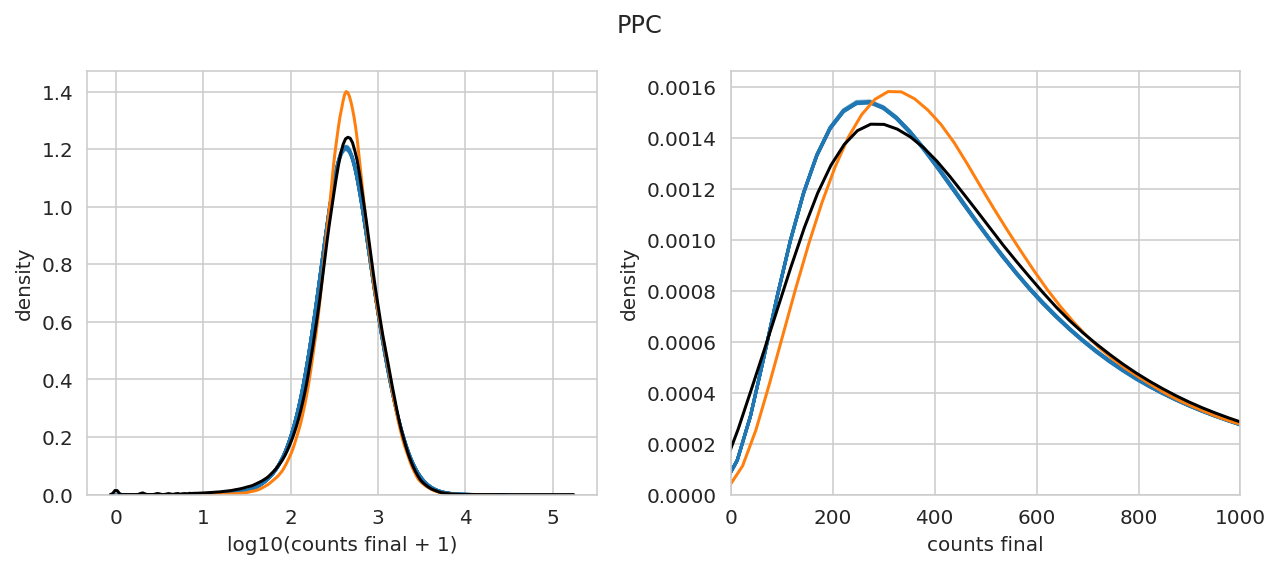

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_liver_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")

x_max = 1000
x_cut = x_max * 5
for i in range(example_ppc_draws.shape[0]):
    x = example_ppc_draws[i, :]
    x = x[x < x_cut]
    sns.kdeplot(x=x, alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg[pp_avg < x_cut], color="tab:orange", ax=ax2)
_obs = valid_liver_data["counts_final"].values
_obs = _obs[_obs < x_cut]
sns.kdeplot(x=_obs, color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, x_max)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [46]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 21.89 minutes


In [47]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-05

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-229.o2.rc.hms.harvard.edu

Git branch: simplify

arviz     : 0.12.1
matplotlib: 3.5.2
pandas    : 1.4.3
numpy     : 1.23.1
seaborn   : 0.11.2

